- Download the dataset
- Use that dataset to train our model
- Download our best model
- Create a flask app
  - Frontend <-> Backend <-> Model

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

!unzip /content/chest-xray-pneumonia.zip -d chest-xray-pneumonia

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Load Pre-trained VGG19 model (excluding top layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the pre-trained layers

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten feature maps
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(2, activation='softmax')(x)  # Ensure this is connected to `x`

model = Model(inputs=base_model.input, outputs=out)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,418,882 (77.89 MB)

 Trainable params: 394,498 (1.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [2]:
# Data Augmentation to improve generalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% Train, 20% Validation
)

# Load Data
dataset_path = "chest-xray-pneumonia/chest_xray"
train_generator = datagen.flow_from_directory(
    dataset_path + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    dataset_path + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [3]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_generator, validation_data=validation_generator, epochs=20, callbacks=[early_stop])

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7056 - loss: 0.5855

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - accuracy: 0.7059 - loss: 0.5850 - val_accuracy: 0.7843 - val_loss: 0.3949
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.8121 - loss: 0.4011 - val_accuracy: 0.8610 - val_loss: 0.3214
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 403s 3s/step - accuracy: 0.8479 - loss: 0.3312 - val_accuracy: 0.8639 - val_loss: 0.3093
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.8712 - loss: 0.2968 - val_accuracy: 0.8686 - val_loss: 0.2848
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 405s 3s/step - accuracy: 0.8665 - loss: 0.2930 - val_accuracy: 0.8581 - val_loss: 0.3017
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 963s 7s/step - accuracy: 0.8798 - loss: 0.2898 - val_accuracy: 0.8792 - val_loss: 0.2661
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.8872 - loss: 0.2546 - val_accuracy: 0.8897 - val_loss: 0.2606
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.8871 - loss: 0.2745 - val_accuracy: 0.883

In [4]:
# Evaluate on test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    dataset_path + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8230 - loss: 0.4685
Test Loss: 0.3280
Test Accuracy: 0.8798


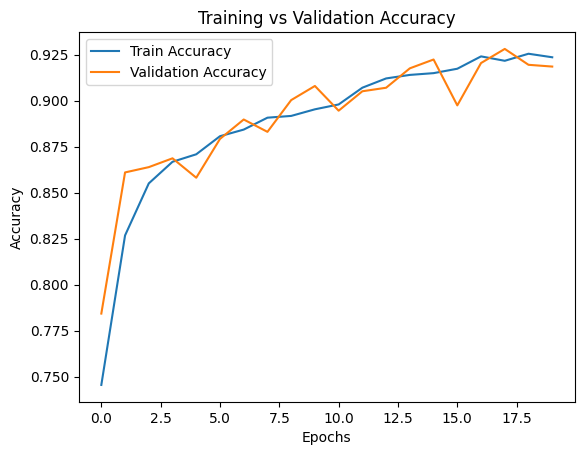

In [5]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [ ]:
# Save model
model.save("pneumonia_vgg19_model.h5")